In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ["KERAS_BACKEND"] = "torch"
import keras

In [3]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [9]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

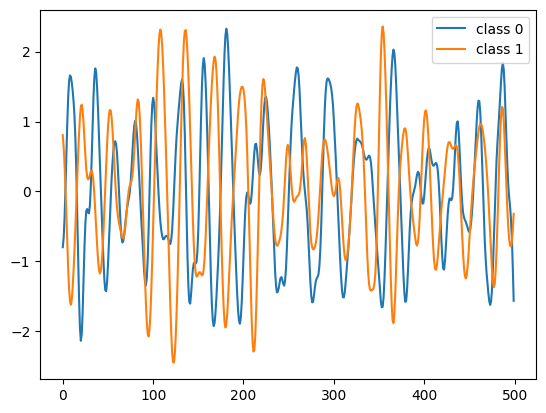

In [10]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()


In [11]:
x_train.shape

(3601, 500, 1)

In [12]:
# Note that the timeseries data used here are univariate, meaning we only have one channel per timeseries example. 
# We will therefore transform the timeseries into a multivariate one with one channel using a simple reshaping via numpy. 
# This will allow us to construct a model that is easily applicable to multivariate time series.

In [13]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_train.shape

(3601, 500, 1)

In [14]:
num_classes = len(np.unique(y_train))
num_classes

2

In [22]:
input_shape = x_train.shape[1:]
input_shape
 

(500, 1)

In [24]:
from keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense

model = keras.models.Sequential([
Input(shape=input_shape),
Conv1D(filters=64, kernel_size=3, padding="same", activation='relu'),
Conv1D(filters=64, kernel_size=3, padding="same", activation='relu'),
Conv1D(filters=64, kernel_size=3, padding="same", activation='relu'),
GlobalAveragePooling1D(),
Dense(num_classes, activation="softmax")
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 500, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,090 (98.01 KB)

 Trainable params: 25,090 (98.01 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.4976 - val_loss: 0.6895 - val_sparse_categorical_accuracy: 0.5548 - learning_rate: 0.0010
Epoch 2/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6760 - sparse_categorical_accuracy: 0.5428 - val_loss: 0.6485 - val_sparse_categorical_accuracy: 0.5589 - learning_rate: 0.0010
Epoch 3/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6431 - sparse_categorical_accuracy: 0.5902 - val_loss: 0.6288 - val_sparse_categorical_accuracy: 0.6796 - learning_rate: 0.0010
Epoch 4/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5963 - sparse_categorical_accuracy: 0.6790 - val_loss: 0.5605 - val_sparse_categorical_accuracy: 0.7184 - learning_rate: 0.0010
Epoch 5/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5571 - sparse_categorical_accuracy: 0.6948 - val_loss: 0.5053 - val_sparse_categorical_accuracy: 0.7531 - learning_rate: 0.0010
Epoch 6/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - 

In [26]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1981 - sparse_categorical_accuracy: 0.9262
Test accuracy 0.9106060862541199
Test loss 0.2142762839794159


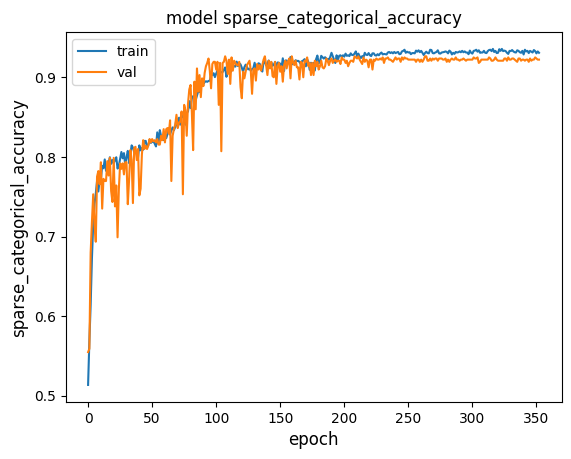

In [27]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()